In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats as stats
import healpy as hp
%matplotlib inline
%config InlineBackend.figure_format='retina'
from SphericalDiff import *
from tqdm import tqdm_notebook as tqdm

In [35]:
Nside=128
Npix=hp.nside2npix(Nside)

In [36]:
# (theta, phi) -> (x,y,z)
def Ang2Vec(theta,phi):
    return np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])

In [69]:
Ampl=1e-8
Sigmal=100
def Cell(ells):
    return Ampl*np.exp(-ells**2/(sigmal**2))

def Xi(theta):
    return Ampl*sigmal**2/(4*np.pi)*np.exp(-theta**2*sigmal**2/4)

In [70]:
#Make gaussian kappa with amplitude and sigma
## let's make a full sky map of gaussiana
def setup_kappa(ampl=1e-8, sigmal=100):
    Ampl=ampl
    Sigmal=sigmal
    ells=np.arange(3*Nside)
    Cl=Cell(ells)
    kappa=hp.synfast(Cl,Nside)
    ## now multiply with a Gaussian taper:
    theta,phi=hp.pix2ang(Nside,np.arange(Npix))
    dec=theta-np.pi/2
    phi[phi>np.pi]=phi[phi>np.pi]-2*np.pi
    kappa*=np.exp(-(dec**2+phi**2)/(2*0.1**2))    
    kappa=SphericalMap(kappa)
    return kappa


In [39]:
# Distribute points in a box of size=(.05 radians)^2 and then displace them with the kappa
def setup_points(kappa, N, size=0.1):
    theta=np.arccos(np.random.uniform(-1*size,1*size,N))
    phi=np.random.uniform(-size,size,N)
    thetap,phip=kappa.DisplaceObjects(theta,phi);
    mpoints = np.array([thetap, phip]).T
    tpoints = np.array([theta, phi]).T
    return tpoints, mpoints

In [176]:
# Given original points, displaced points, and cutoff radius, generate the data vector and associated noise
def make_kappa(tpoints, mpoints, sradius, noiseofs=0.0, noisemult=1.0):
    new_kappa = []
    new_noise = []
    noisevar = []
    id1 = []
    id2 = []
    num_dots = len(tpoints)
    for i in tqdm(range(num_dots)):
        for j in range(i):
            vit = Ang2Vec(*tpoints[i])
            vjt = Ang2Vec(*tpoints[j])
            true_dist = np.linalg.norm(vit - vjt)
            if true_dist < sradius:
                id1.append(i)
                id2.append(j)
                vim = Ang2Vec(*mpoints[i])
                vjm = Ang2Vec(*mpoints[j])
                mod_dist = np.linalg.norm(vim - vjm)
                noise_rms = noiseofs+noisemult*true_dist
                noise_sig = noise_rms*np.random.normal(0,1)
                noisevar.append(noise_rms**2)
                new_kappa.append((mod_dist - true_dist)/true_dist)
                new_noise.append(noise_sig)
    new_kappa=np.array(new_kappa)
    new_noise=np.array(new_noise)
    noisevar=np.array(noisevar)
    return id1, id2, new_kappa, new_noise, noisevar

In [41]:
# Generate clte/cltt and clte/sqrt plots given the CLs
def make_plots(true, reconstruct, plot, title = "prak"):
    cltt = hp.anafast(true_kap, true_kap)
    clte = hp.anafast(true_kap, reconstruct)
    clee = hp.anafast(reconstruct, reconstruct)
    plot1 = (clte/cltt)[1:]
    plot2 = (clte/np.sqrt(cltt*clee))[1:]
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].plot(clte/cltt)
        ax[0].set_title(title + " - clte/cltt")
        ax[1].plot(clte/np.sqrt(cltt*clee))
        ax[1].set_title(title + " - clte/sqrt")
    return plot1, plot2
    

In [42]:
# Make a diagonal sparse matrix which has values of 1/noise
def make_noise_inverse(noisevar):
    size = len(noisevar)
    cleaned_noise = [1/n if n!=0 else 1 for n in noisevar]
    dia_n = sp.sparse.dia_matrix((cleaned_noise, 0), shape=(size,size)).tocsc()
    return dia_n

In [43]:
# Setup needed for midpoint method
def mid_setup(id1, id2, mpoints):
    p1 = []
    p2 = []
    for i in tqdm(range(len(id1))):
        p1.append(Ang2Vec(*mpoints[id1[i]]))
        p2.append(Ang2Vec(*mpoints[id2[i]]))
    np1 = np.array(p1)
    np2 = np.array(p2)
    return np1, np2

In [44]:
#Setup needed for optimal method
def optimal_setup(tpoints):
    pixid = np.array(list(set(hp.ang2pix(Nside, tpoints[:,0], tpoints[:,1]))))
    hpx = {}
    pxd = {}
    for c,v in enumerate(pixid):
        hpx[v] = hp.pix2vec(Nside,v)
        pxd[v] = c
    hpix=hpx
    pixdict = pxd
    sigma=np.sqrt(4*np.pi/(12*Nside**2))        
    sigweight = 2*sigma**2

    return pixid, hpix, pixdict, sigweight

In [45]:
# Concise midpoint estimator
def big_mid(p1, p2, kappa, noisevar):
    m1 = (p1+p2)*.5
    mid = m1/np.linalg.norm(m1)
    hp_points = hp.vec2pix(Nside, mid.T[0], mid.T[1], mid.T[2])
    signal = np.bincount(hp_points, weights=kappa/noisevar, minlength=Npix)
    weight = np.bincount(hp_points, weights=1/noisevar, minlength=Npix)
    return signal, weight

In [167]:
#Optimal estimator
def optimal(qid1, qid2, kappa, sradius, noisevar):
    data = []
    rows = []
    columns = []
    Nd = len(kappa)
    Np = len(pixid)
    pixarea = hp.nside2pixarea(Nside, False)

    for j in tqdm(range(Nd)):
        qtheta1=mpoints[qid1[j]][0]
        qphi1=mpoints[qid1[j]][1]
        qtheta2=mpoints[qid2[j]][0]
        qphi2=mpoints[qid2[j]][1]
        
        q1 = Ang2Vec(qtheta1, qphi1)
        q2 = Ang2Vec(qtheta2, qphi2)
        neipixels1=hp.query_disc(Nside, q1, sradius)
        neipixels2=hp.query_disc(Nside, q2, sradius)
        s = np.intersect1d(neipixels1, neipixels2)
        ss = set(s)
        smols = np.array([*ss.intersection(pixid)])
        jthrow = [pixdict[l] for l in smols]
        if (smols.shape[0] == 0):
            continue
        ms = np.array([hpix[x] for x in smols])

        d1 = q1 - ms
        d2 = q2 - ms

        norm1 = np.sqrt(np.einsum('ij,ij->i', d1, d1))       #Faster way to calculate norms
        norm2 = np.sqrt(np.einsum('ij,ij->i', d2, d2))

        resp1=1/norm1*(1-np.exp(-norm1**2/(2*sigweight)))
        resp2=1/norm2*(1-np.exp(-norm2**2/(2*sigweight)))

        drr = (d1.T*resp1).T - (d2.T*resp2).T
        dr = d1 - d2
        if dr.any()==0:
            print("fuck shit up")

        totresponse = -2*pixarea*np.einsum('ij,ij->i', drr, drr)/np.einsum('ij,ij->i',dr,dr)
        #totresponse *= np.sqrt(noise[j])
        data += list(totresponse)
        rows += [j]*len(jthrow)
        columns += jthrow

    print("Creating A matrix...")
    A = sp.sparse.csr_matrix((data, (rows, columns)), shape=(Nd, Np))
    return A

In [47]:
# Following COBE method of mapmaking
def cobe_makemap(A, Ninv, x):
    print("Making map")
    At = A.T
    print("Calculating W....")
    X = At@Ninv@A
    Y = At@Ninv@x
    cmap = optimal_makemap(X, Y)[0]
    return cmap

In [48]:
# Following WIENER 2
def wiener2_makemap(A, Ninv, Sinv, x):
    print("Making map")
    At = A.T
    print("Calculating W....")
    X = Sinv + At@Ninv@A
    Y = At@Ninv@x
    wmap = optimal_makemap(X, Y)[0]
    return wmap

In [49]:
# Kappa estimator using law of cosines
def prak_makemap(qid1, qid2, kappa, origins):
    kap_map = []
    for j in tqdm(range(len(kappa))):
        d = kappa[j]
        qtheta1=mpoints[qid1[j]][0]
        qphi1=mpoints[qid1[j]][1]
        qtheta2=mpoints[qid2[j]][0]
        qphi2=mpoints[qid2[j]][1]

        q1 = Ang2Vec(qtheta1, qphi1)
        q2 = Ang2Vec(qtheta2, qphi2)

        c1 = np.linalg.norm(q1 - q2)
        c = c1/(d + 1)
        a1 = np.linalg.norm(q1 - origins, axis=1)
        a = c/c1*a1
        k = a*(a1 - a)/2
        kap_map.append(k)
        
    return np.array(kap_map)

In [50]:
# Wrapper function for scipy sparse lsmr
def optimal_makemap(A, b):
    print("running solver")
    mp = sp.sparse.linalg.lsmr(A,b)
    return mp

In [51]:
# Create map given signal and weight
def mid_makemap(s,w):
    fullmap = s/w
    midmap = np.array(list(map(lambda x: x if ~np.isnan(x) else 0, fullmap)))
    return midmap

In [52]:
# Given a small array of relevant pixels (pixid), create a full sized kappa map.
def small2big(data):
    big = np.zeros(Npix)
    big[pixid] = data
    return big
smol2big=small2big

In [53]:
# Calculate Sinv for WIENER2
#def calculate_Sinv(true_kap, mapsize):
#    truk_cl = hp.anafast(true_kap, alm=False)
##    lmax = len(truk_cl)
#    pixcl = hp.pixwin(Nside)[:lmax]
##    tru_cl_pix = pixcl**2*truk_cl
#    variance = 0
#    for i in range(len(truk_cl)):
#        variance += (2*i+1)/(4*np.pi)*tru_cl_pix[i]
#    S_mat = make_noise_inverse([variance]*mapsize)
#    return S_mat

In [54]:
# Remove values that are "too small"/essentially 0 to speed things up a bit
def clean_array(ar, tol = 1e-8):
    return np.array(list(map(lambda x: x if abs(x) > tol else 0, ar)))

In [55]:
# COBE map
def cobe():
    N = make_noise_inverse(noise)
    dat = cobe_makemap(A, N, kappa)
    cobemap = small2big(dat)
    c1, c2 = make_plots(true_kap, cobemap, False, 'COBE')
    return c1, c2

In [88]:
# Wiener map
def wiener():
    Ninv = make_noise_inverse(noise)
    Sinv = make_noise_inverse(Xi(0)*np.ones(A.shape[1]))
    dat = wiener2_makemap(A, Ninv, Sinv, kappa)
    wienermap = small2big(dat)
    w1, w2 = make_plots(true_kap, wienermap, False, 'Wiener')
    return w1, w2

In [91]:
# Midpoint map 
def mid():
    np1, np2 = mid_setup(id1, id2, mpoints)
    s,w = big_mid(np1, np2, kappa,noisevar)
    midmap = mid_makemap(-s,w)
    m1, m2 = make_plots(true_kap, midmap, False, 'Midpoint')
    return m1, m2

In [74]:
# LSMR map method
def direct_lsmr():
    m = optimal_makemap(A, kappa)[0]
    optmap = small2big(m)
    optmap_test = optmap*1
    l1, l2 = make_plots(true_kap, optmap_test, False, 'lsmr')
    return l1, l2

In [75]:
# Use all 4 methods to create clte/cltt and clte/sqrt plots
def legend_plots():
    l1, l2 = direct_lsmr()
    c1, c2 = cobe()
    w1, w2 = wiener()
    m1, m2 = mid()
    
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    
    ax[0].plot(l1, label='lsmr')
    ax[0].plot(c1, label='cobe')
    ax[0].plot(w1, label='wiener')
    ax[0].plot(m1, label='mid')
    ax[0].legend()
    ax[0].set_title("clte/cltt")
    ax[1].plot(l2, label='lsmr')
    ax[1].plot(c2, label='cobe')
    ax[1].plot(w2, label='wiener')
    ax[1].plot(m2, label='mid')
    ax[1].legend()
    ax[1].set_title("clte/sqrt")
    

In [76]:
# Create kappa and clean the array
# setup_kappa(amplitude, sigma)
kappamap = setup_kappa(1e-5,100)
true_kap = clean_array(kappamap.A, tol=0)

/home/anze/anaconda3/lib/python3.6/site-packages/healpy/sphtfunc.py:395: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [77]:
%%capture
# Distribute points using kappamap
# setup_points(kappamap, size of side of square Number of points)
tpoints, mpoints = setup_points(kappamap, 500)

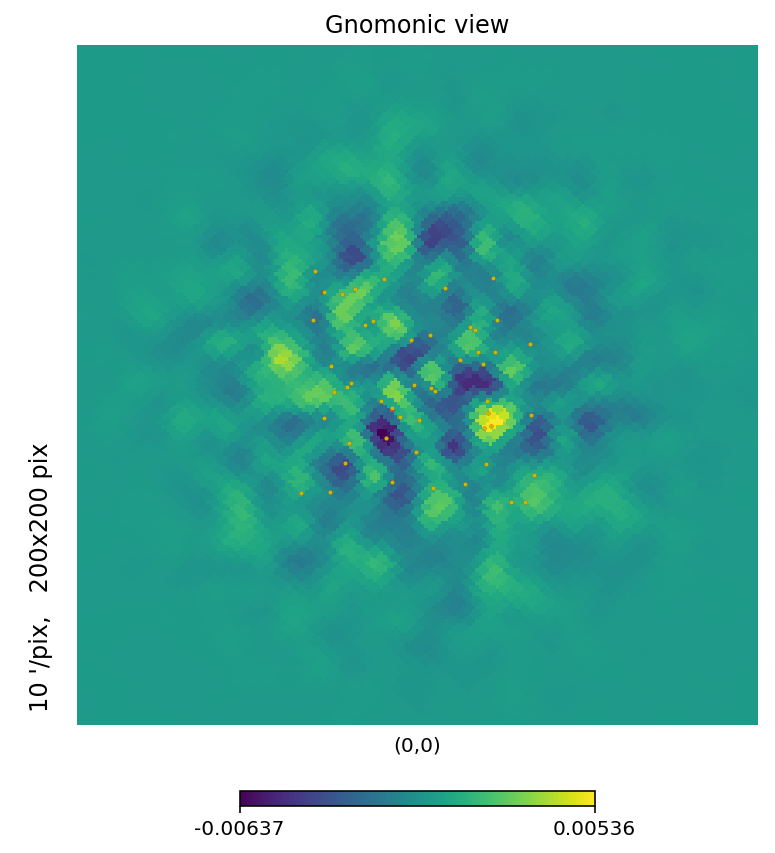

In [78]:
hp.gnomview(kappamap.A,reso=10)
plt.plot(tpoints[:50,0]-np.pi/2,tpoints[:50,1],'r.',markersize=2)
plt.plot(mpoints[:50,0]-np.pi/2,mpoints[:50,1],'y.',markersize=2)

In [177]:
# Creates data vector and noise vector
# make_kappa(tpoints, mpoints, search_radius)
id1, id2, kappa_noiseless, noise, noisevar = make_kappa(tpoints, mpoints, 5/180*np.pi,noiseofs=1e-3,noisemult=0)
kappa=kappa_noiseless+noise

In [178]:
# Run optimal estimator
# optimal(id1, id2, kappa, search_radius for estimator, noise)
pixid, hpix, pixdict, sigweight= optimal_setup(tpoints)
A = optimal(id1, id2, kappa, 1/180*np.pi, noisevar)


Creating A matrix...


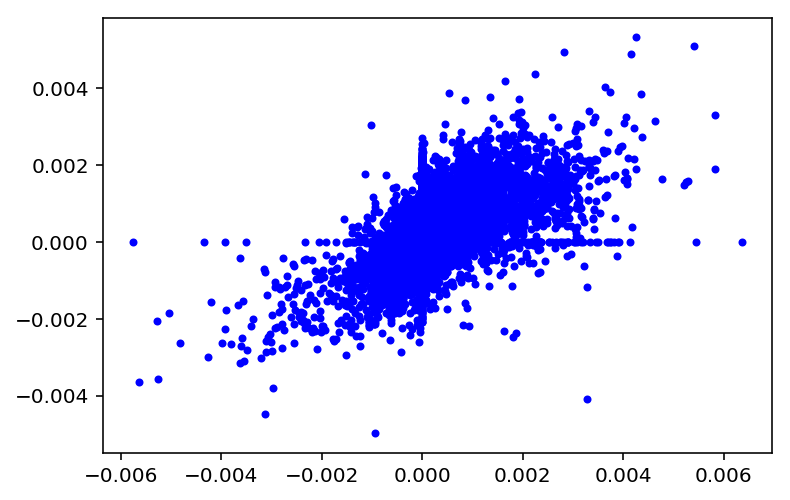

In [179]:
res=A@kappamap.A[pixid]
plt.plot(res,kappa_noiseless,'b.')


running solver
Making map
Calculating W....
running solver
Making map
Calculating W....
running solver


/home/anze/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/anze/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


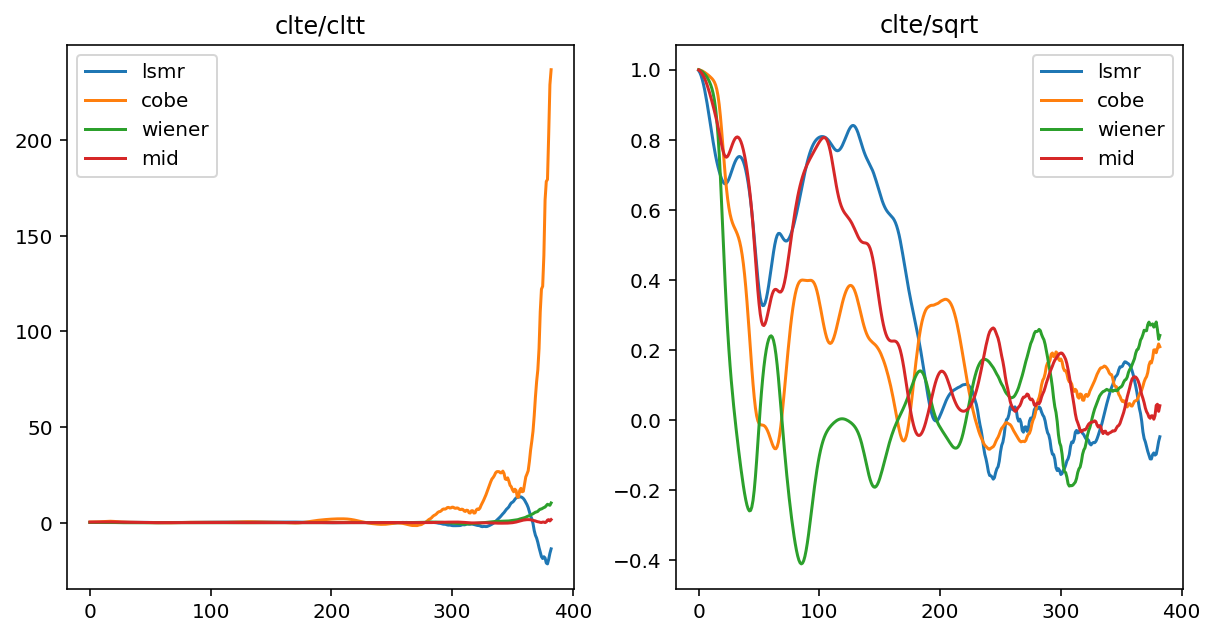

In [180]:
# Create plots
legend_plots()